# Machine Learning Fundamentals - Lecture 05

This is the Jupyter notebook for Lecture 05 of the Machine Learning Fundamentals
course.

In [15]:
# Import the required libraries using the commonly use short names (pd, sns, ...)
import numpy as np
import pandas as pd

# This allows us to specify Python types in our functions, which then helps in
# auto-completing our code when we use those functions
from numpy.typing import NDArray

# The Path object from pathlib allows us to easily build paths in an
# OS-independent fashion
from pathlib import Path

# This will help us cycle through the predefined color list (colormap) of a
# matplotlib plot
from itertools import cycle

# Load the required scikit-learn classes and functions
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

# Load matplotlib
import matplotlib.pyplot as plt

# Get the colors array from the current matplotlib colormap
# We'll cycle through these predefined colors in each plot to keep consistency
# and so that our plots don't look horrible with colors chosen by us
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [16]:
# Load the dataset (note the use of the Path object)
df = pd.read_csv(Path("..", "datasets", "Pokemon.csv"))

# It's not good practice to have column names with spaces and other non-standard
# characters, so let's fix this by renaming the columns to standard names
df.rename(columns={
    "Type 1" : "Type1",
    "Type 2" : "Type2",
    "Sp. Atk" : "SpAtk",
    "Sp. Def" : "SpDef",
}, inplace=True)

# Replace missing values in the "Type2" column with the string "None"
df["Type2"] = df["Type2"].fillna("None")

# Since primary and secondary types are essentially categories (and not just
# strings / objects), we can convert these columns to the category type
df["Type1"] = df["Type1"].astype("category")
df["Type2"] = df["Type2"].astype("category")

## Our own 1D linear regressor

In [17]:
# Let's try this out by predicting total from a single feature: Attack
X1d = df[["Attack"]].to_numpy()
y1d = df[["Total"]].to_numpy()

# Let's split our data into training (80%) and test (20%) sets
# Change the random_state parameter do split data in different ways
X1d_train, X1d_test, y1d_train, y1d_test = train_test_split(X1d, y1d, test_size=0.2, random_state=42)

In [18]:
# Here's our 1D linear regression class
class LinReg1D:

    # Method for training the model, i.e., performing the fit()
    def fit(self, x_train: NDArray, y_train: NDArray):

        # Make sure our x and y are 1D arrays
        x_train = x_train.ravel()
        y_train = y_train.ravel()

        # Get the mean of x and y
        mx = x_train.mean()
        my = y_train.mean()

        # Apply the formula for m
        m = np.sum((x_train - mx) * (y_train - my)) / np.sum((x_train - mx) ** 2)

        # Apply the formula for b
        b = my - m * mx

        # Keep m and b within this object
        self.m = m
        self.b = b

    # Method for performing the prediction
    def predict(self, x_test: NDArray):

        # Simply apply the line equation
        return self.m * x_test.ravel() + self.b

In [19]:
# Let's try out our own 1D linear regression implementation
lr1d = LinReg1D()

# Follow the typical steps: fit (train) and predict (infer)
lr1d.fit(X1d_train, y1d_train)
y1d_pred = lr1d.predict(X1d_test)

# Check out the R^2 score for out 1D linear regressor
lr1d_r2 = r2_score(y1d_test, y1d_pred)

print(f"R² score for our linear regressor: {lr1d_r2}")

R² score for our linear regressor: 0.5680252046719954


In [20]:
# Test scikit-learn's linear regressor
lrskl = LinearRegression()

# Follow the typical steps: fit (train) and predict (infer)
lrskl.fit(X1d_train, y1d_train)
y_skl_pred = lrskl.predict(X1d_test)

# Check out the R^2 score for scikit-learn's linear regressor
lrskl_r2 = r2_score(y1d_test, y_skl_pred)

print(f"R² score for Scikit-learn's linear regressor: {lrskl_r2}")

R² score for Scikit-learn's linear regressor: 0.5680252046719954


Looking at both $R^2$ scores, we can observe that we obtain the exact same
result.

Let's draw a plot comparing the two predictions:

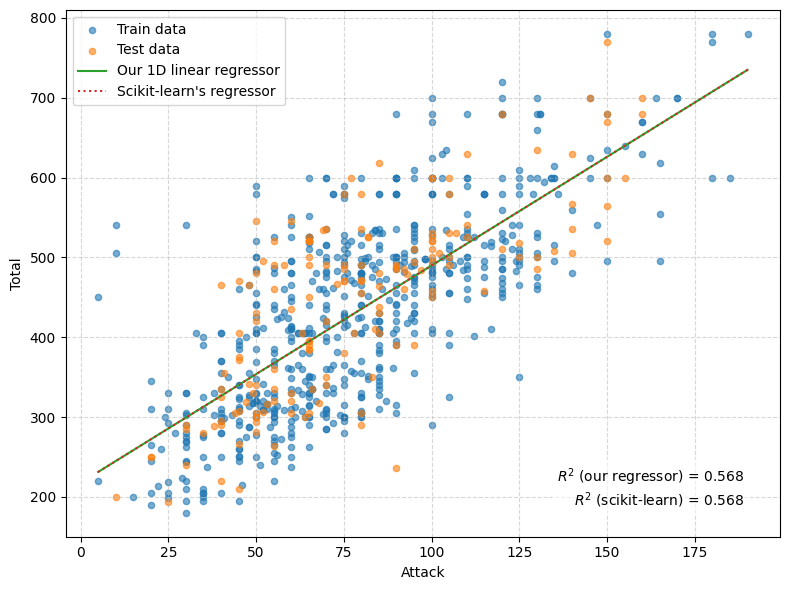

In [21]:
# Create a new color cycler
cycler = cycle(colors)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# First, plot the training data
ax.scatter(X1d_train, y1d_train, s=20, color=next(cycler), alpha=0.6, label="Train data")

# Then the test data
ax.scatter(X1d_test.ravel(), y1d_test, s=20, color=next(cycler), alpha=0.6, label="Test data")

# Create test grid for plotting the regression lines
X_pred_plot = np.linspace(X1d.min(), X1d.max(), 500).reshape(-1, 1)
y_pred_plot_rl1d = lr1d.predict(X_pred_plot)    # Ours
y_pred_plot_rlskl = lrskl.predict(X_pred_plot)  # Scikit-learn's

# Now let's plot the regression lines for each regressor
ax.plot(X_pred_plot, y_pred_plot_rl1d, color=next(cycler), linewidth=1.5, label="Our 1D linear regressor")
ax.plot(X_pred_plot, y_pred_plot_rl1d, color=next(cycler), linewidth=1.5, linestyle="dotted", label="Scikit-learn's regressor")

# Labels, legend, and background grid
ax.set_xlabel("Attack")
ax.set_ylabel("Total")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)

# Present the R^2's directly in the figure
ax.text(
    0.95, 0.05, # (x, y) in axes fraction coordinates
    f"$R^2$ (our regressor) = {lr1d_r2:.3f}\n$R^2$ (scikit-learn) = {lrskl_r2:.3f}",
    transform=ax.transAxes, # interpret (x, y) as fraction of Axes
    ha="right", va="bottom", # align text to right bottom corner
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
)

fig.tight_layout()

## Implement a multi-dimensional regressor

In [22]:
# Let's use all features except Speed, otherwise we'll get a perfect regression
# (since Total is literally the sum of all features)
features = ["HP", "Attack", "Defense", "SpAtk", "SpDef" ] #, "Speed"]

# Get only the specified features
X = df[features].to_numpy()

# Our target values will the the "Total" column
y = df["Total"].to_numpy()

# Let's split our data into training (80%) and test (20%) sets
# Change the random_state parameter do split data in different ways
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Here's our multidimensional linear regression class (also works in 1D!)
class LinReg:

    # Method for training the model, i.e., performing the fit()
    def fit(self, X_train: NDArray, y_train: NDArray):

        # Add a first column of ones
        X = np.concat((np.ones((X_train.shape[0], 1)), X_train), axis=1)

        # Apply the general OLS formula to obtain the regression coefficients
        # and keep them in the object
        self.B = np.linalg.inv(X.T @ X) @ X.T @ y_train

    # Method for performing the prediction
    def predict(self, X_test: NDArray):

        # Add a first column of ones
        X = np.concat((np.ones((X_test.shape[0], 1)), X_test), axis=1)

        # Apply the line equation
        return X @ self.B

In [24]:
# Let's try out our own multidimensional linear regression implementation
lrnd = LinReg()

# Follow the typical steps: fit (train) and predict (infer)
lrnd.fit(X_train, y_train)
ynd_pred = lrnd.predict(X_test)

# Check out the R^2 score for out multidimensional linear regressor
lrnd_r2 = r2_score(y_test, ynd_pred)

print(f"R² score for our linear regressor: {lrnd_r2}")

R² score for our linear regressor: 0.9588834298188773


In [25]:
# Test scikit-learn's linear regressor
lrskl = LinearRegression()

# Follow the typical steps: fit (train) and predict (infer)
lrskl.fit(X_train, y_train)
yskl_pred = lrskl.predict(X_test)

# Check out the R^2 score for scikit-learn's linear regressor
lrskl_r2 = r2_score(y_test, yskl_pred)

print(f"R² score for Scikit-learn's linear regressor: {lrskl_r2}")

R² score for Scikit-learn's linear regressor: 0.9588834298188773


Looking at both $R^2$ scores, we can observe that we obtain the exact same
result.

Let's now test various regularized linear regressors (with their default
values), as well as polynomial linear regression, to check if $R^2$ increases.

In [26]:
# For Ridge, Lasso, and ElasticNet, we need to scale
ss = StandardScaler()

# Fit only on training data, then transform (scale) it
X_train_scaled = ss.fit_transform(X_train)

# Use the same transformation on test data
X_test_scaled = ss.transform(X_test)

In [27]:
# Reprint the R^2 score for OLS linear regression, for comparison
print(f"R² score for OLS linear regression: {lrskl_r2}")

# Let's start with Ridge linear regression
ridge = Ridge()

ridge.fit(X_train_scaled, y_train)
ridge_pred = ridge.predict(X_test_scaled)
ridge_r2 = r2_score(y_test, ridge_pred)

print(f"R² score for Ridge regression: {ridge_r2}")

# Now Lasso
lasso = Lasso()

lasso.fit(X_train_scaled, y_train)
lasso_pred = lasso.predict(X_test_scaled)
lasso_r2 = r2_score(y_test, lasso_pred)

print(f"R² score for Lasso regression: {lasso_r2}")

# ElasticNet: combining Ridge and Lasso
enet = ElasticNet()

enet.fit(X_train_scaled, y_train)
enet_pred = enet.predict(X_test_scaled)
enet_r2 = r2_score(y_test, enet_pred)

print(f"R² score for Elastic Net: {enet_r2}")

# Now lets try out polynomial regression with different degrees: 2, 5, 10
# We'll use the pipeline approach. Note that polynomial features are obtained
# before scaling. Why? Here's a good explanation:
# When you create feature interactions, you’re generating values that are
# multiples and squares of themselves. By creating interactions between
# z-score sized values, you’ll get values a magnitude smaller than the original.
# The purpose of squaring values in PolynomialFeatures is to increase signal. To
# retain this signal, it’s better to generate the interactions first then
# standardize second.
# Source: https://samchaaa.medium.com/preprocessing-why-you-should-generate-polynomial-features-first-before-standardizing-892b4326a91d

# Degree = 2
poly2 = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lin_reg", LinearRegression())
])

poly2.fit(X_train, y_train)
poly2_pred = poly2.predict(X_test)
poly2_r2 = r2_score(y_test, poly2_pred)

print(f"R² score for Poly2: {poly2_r2}")

# Degree = 5
poly5 = Pipeline([
    ("poly_features", PolynomialFeatures(degree=5, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lin_reg", LinearRegression())
])

poly5.fit(X_train, y_train)
poly5_pred = poly5.predict(X_test)
poly5_r2 = r2_score(y_test, poly5_pred)

print(f"R² score for Poly5: {poly5_r2}")

# Degree = 10
poly10 = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lin_reg", LinearRegression())
])

poly10.fit(X_train, y_train)
poly10_pred = poly10.predict(X_test)
poly10_r2 = r2_score(y_test, poly10_pred)

print(f"R² score for Poly10: {poly10_r2}")

R² score for OLS linear regression: 0.9588834298188773
R² score for Ridge regression: 0.958932799363037
R² score for Lasso regression: 0.9593019475945344
R² score for Elastic Net: 0.9342882171202535
R² score for Poly2: 0.9590600432457591
R² score for Poly5: -1.5012534326672902
R² score for Poly10: -3608330.6366387308


Lasso behaves better here, with an $R^2$ score of $0.9593$, followed by
polynomial linear regression with degree 2 with $R^2=0.9590$. Higher degree
polynomials are clearly detrimental, as they overfit the training data and are
unable to generalize for the test data.

## Polynomial intuition

In this final part, we'll plot the 1D regression with OLS linear regression and
compare it with several degrees of polynomial regression, so we get an intuition
on how it works. 

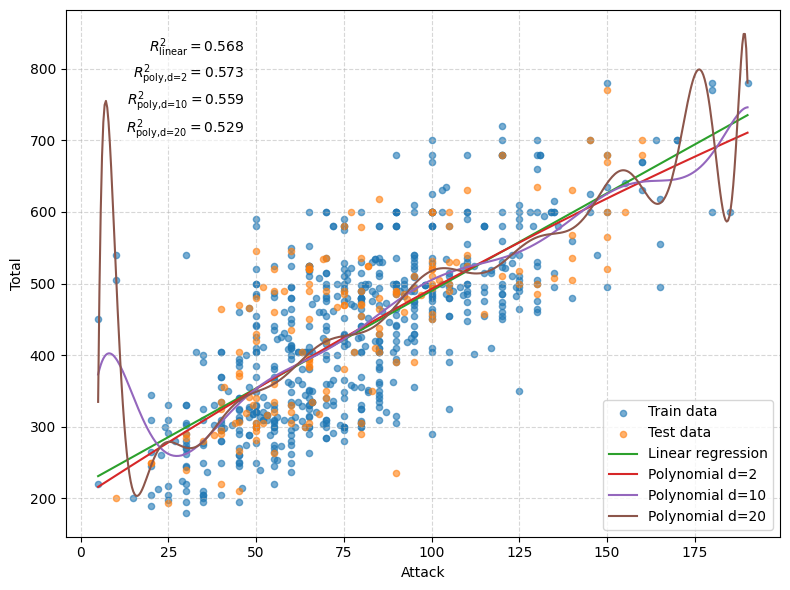

In [28]:
# Create a new color cycler
cycler = cycle(colors)

# A standard OLS linear regressor
lr = LinearRegression()

# Polynomial regressors with various degrees: 2, 10, 20
poly2 = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lin_reg", LinearRegression())
])
poly10 = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lin_reg", LinearRegression())
])
poly20 = Pipeline([
    ("poly_features", PolynomialFeatures(degree=20, include_bias=False)),
    ("scaler", StandardScaler()),
    ("lin_reg", LinearRegression())
])

# Train regressors
lr.fit(X1d_train, y1d_train)
poly2.fit(X1d_train, y1d_train)
poly10.fit(X1d_train, y1d_train)
poly20.fit(X1d_train, y1d_train)

# Get predictions on test data
y_pred_lr = lr.predict(X1d_test)
y_pred_p2 = poly2.predict(X1d_test)
y_pred_p10 = poly10.predict(X1d_test)
y_pred_p20 = poly20.predict(X1d_test)

# Obtain R²'s
r2_lr = r2_score(y1d_test, y_pred_lr)
r2_p2 = r2_score(y1d_test, y_pred_p2)
r2_p10 = r2_score(y1d_test, y_pred_p10)
r2_p20 = r2_score(y1d_test, y_pred_p20)

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# First, plot the training data
ax.scatter(X1d_train, y1d_train, s=20, color=next(cycler), alpha=0.6, label="Train data")

# Then the test data
ax.scatter(X1d_test.ravel(), y1d_test, s=20, color=next(cycler), alpha=0.6, label="Test data")

# Create test grid for plotting the regression lines
X_pred_plot = np.linspace(X1d.min(), X1d.max(), 500).reshape(-1, 1)
y_pred_plot_lr = lr.predict(X_pred_plot)
y_pred_plot_p2 = poly2.predict(X_pred_plot)
y_pred_plot_p10 = poly10.predict(X_pred_plot)
y_pred_plot_p20 = poly20.predict(X_pred_plot)

# Now let's plot the regression lines for each regressor
ax.plot(X_pred_plot, y_pred_plot_lr, color=next(cycler), label="Linear regression")
ax.plot(X_pred_plot, y_pred_plot_p2, color=next(cycler), label="Polynomial d=2")
ax.plot(X_pred_plot, y_pred_plot_p10, color=next(cycler), label="Polynomial d=10")
ax.plot(X_pred_plot, y_pred_plot_p20, color=next(cycler), label="Polynomial d=20")

# Labels, legend, and background grid
ax.set_xlabel("Attack")
ax.set_ylabel("Total")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)

# Present the R^2's directly in the figure
ax.text(
    0.25, 0.95, # (x, y) in axes fraction coordinates
    r"$R^2_{\text{linear}}=" + f"{r2_lr:.3f}" + "$\n" +
    r"$R^2_{\text{poly,d=2}}=" + f"{r2_p2:.3f}" + "$\n" +
    r"$R^2_{\text{poly,d=10}}=" + f"{r2_p10:.3f}" + "$\n" +
    r"$R^2_{\text{poly,d=20}}=" + f"{r2_p20:.3f}" + "$",
    transform=ax.transAxes, # interpret (x, y) as fraction of Axes
    ha="right", va="top",
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
)

fig.tight_layout()

As we can observe, for polynomial regression with degree 2, the $R^2$ score
improves a bit with respect to OLS linear regression. However, increasing the
degree can make the regression overfit the training data, and thus generalize
poorly to the test data. This can be observed in the lower values of $R^2$ for
degree 10 and 20, but not to the extent we saw in the multidimensional case.
Since the 1D case is much simpler, the overfit will never be as bad as in the
multidimensional case.